# **Transformer Interpretability Beyond Attention Visualization**

Paper: https://arxiv.org/abs/2012.09838

In [1]:
!git clone https://github.com/hila-chefer/Transformer-Explainability.git

import os
os.chdir(f'./Transformer-Explainability')

!pip install einops

fatal: destination path 'Transformer-Explainability' already exists and is not an empty directory.
/home/18193/sdd-env/env_acne/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/home/18193/sdd-env/env_acne/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
You should consider upgrading via the '/home/18193/sdd-env/env_acne/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from modules.layers_ours import *
import torch
import numpy as np
import cv2
import timm
from collections import OrderedDict
import sys
sys.path.append('../../')
from src.utils.gcs_utils import *
import pickle

In [3]:
bucket = get_bucket_gcs('oro-ds-test-bucket')
blob = bucket.blob('sdd_acne_files/Merged_for_ensemble/vit.pth')
blob._chunk_size = 8388608  # 1024 * 1024 B * 16 = 8 MB
blob.download_to_filename('../vit.pth')


Here are the list of classes

In [4]:
blob = bucket.blob('sdd_acne_files/Merged_for_ensemble/vit_class_indices.pkl')
pickle_in = blob.download_as_string()
my_dictionary = pickle.loads(pickle_in)
CLS2IDX = my_dictionary

In [5]:
CLS2IDX

{0: 'acne_mixed',
 1: 'acne_scars',
 2: 'atopic_dermatitis',
 3: 'acne_cystic',
 4: 'acne_excoriated',
 5: 'rosacea_inflammatory',
 6: 'rosacea_erythemato_telangiectasique',
 7: 'acne_comedos',
 8: 'peri_oral_dermatitis',
 9: 'seborrheic_keratosis',
 10: 'psoriasis_vulgar',
 11: 'seborrheic_dermatitis',
 12: 'nummular_eczema',
 13: 'tinea_versicolor',
 14: 'chronic_hand_eczema',
 15: 'vulgar_warts',
 16: 'folliculitis',
 17: 'alopecia_androgenic',
 18: 'dyshidrosis',
 19: 'nevus',
 20: 'melasma',
 21: 'alopecia_areata',
 22: 'intertrigo',
 23: 'urticaria',
 24: 'vitiligo',
 25: 'keratosis_pilaris',
 26: 'molluscum',
 27: 'cheilitis_eczematous',
 28: 'tinea_corporis',
 29: 'prurigo_nodularis',
 30: 'actinic_keratosis',
 31: 'genital_warts',
 32: 'plane_warts',
 33: 'pityriasis_rosae',
 34: 'melanonychia',
 35: 'psoriasis_pustular_palmoplantar',
 36: 'granuloma_annulare',
 37: 'psoriasis_guttate',
 38: 'lichen_simplex_chronicus',
 39: 'shingles',
 40: 'herpes_simplex'}

# **ViT Model**

In [6]:
from baselines.ViT.ViT_LRP import vit_base_patch16_224 as vit_LRP
from baselines.ViT.ViT_explanation_generator import LRP
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
normalize = transforms.Normalize(mean=mean, std=std)
transform = transforms.Compose([
    transforms.Resize((224,224)),
    #transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])
resizing =  transforms.Resize((224,224))

# create heatmap from mask on image
def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return cam

# initialize ViT pretrained
model =  vit_LRP(pretrained=True)#timm.create_model('vit_base_patch16_224', num_classes=41)
num_ftrs = model.head.in_features
model.head = Linear(num_ftrs, 41)
state_dict = torch.load('../vit.pth')
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:]  # remove `module.`
    new_state_dict[name] = v
print("[Loading Weights to the Model]")
model.load_state_dict(new_state_dict)
model.cuda()
model.eval()

attribution_generator = LRP(model)

def generate_visualization(original_image, class_index=None):
    transformer_attribution = attribution_generator.generate_LRP(original_image.unsqueeze(0).cuda(), method="transformer_attribution", index=class_index).detach()
    transformer_attribution = transformer_attribution.reshape(1, 1, 14, 14)
    transformer_attribution = torch.nn.functional.interpolate(transformer_attribution, scale_factor=16, mode='bilinear')
    transformer_attribution = transformer_attribution.reshape(224, 224).cuda().data.cpu().numpy()
    transformer_attribution = (transformer_attribution - transformer_attribution.min()) / (transformer_attribution.max() - transformer_attribution.min())
    image_transformer_attribution = original_image.permute(1, 2, 0).data.cpu().numpy()
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())
    vis = show_cam_on_image(image_transformer_attribution, transformer_attribution)

    vis =  np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    return vis

def print_top_classes(predictions, **kwargs):    
    # Print Top-5 predictions
    prob = torch.softmax(predictions, dim=1)
    class_indices = predictions.data.topk(5, dim=1)[1][0].tolist()
    max_str_len = 0
    class_names = []
    for cls_idx in class_indices:
        class_names.append(CLS2IDX[cls_idx])
        if len(CLS2IDX[cls_idx]) > max_str_len:
            max_str_len = len(CLS2IDX[cls_idx])
    
    print('Top 5 classes:')
    for cls_idx in class_indices:
        output_string = '\t{} : {}'.format(cls_idx, CLS2IDX[cls_idx])
        output_string += ' ' * (max_str_len - len(CLS2IDX[cls_idx])) + '\t\t'
        output_string += 'value = {:.3f}\t prob = {:.1f}%'.format(predictions[0, cls_idx], 100 * prob[0, cls_idx])
        print(output_string)

[Loading Weights to the Model]


In [7]:
def image_reader(bucket, image):
    image_read = cv2.cvtColor(cv2.imdecode(np.asarray(bytearray(bucket.blob(image).download_as_string()), dtype=np.uint8),cv2.IMREAD_COLOR),cv2.COLOR_BGR2RGB)
    return image_read


In [8]:
images = ['sdd_acne_files/shanel_images/PXL_20211114_184920576.jpg','sdd_acne_files/shanel_images/PXL_20220419_203530160.jpg',
         'sdd_acne_files/shanel_images/PXL_20220506_215317846.jpg','sdd_acne_files/shanel_images/PXL_20220509_191251054.MP.jpg',
         'sdd_acne_files/shanel_images/PXL_20210312_145539241.jpg']
diseases = [14, 9, 13, 24, 0, 24]

Top 5 classes:
	14 : chronic_hand_eczema            		value = 9.150	 prob = 56.8%
	18 : dyshidrosis                    		value = 8.651	 prob = 34.5%
	10 : psoriasis_vulgar               		value = 6.780	 prob = 5.3%
	35 : psoriasis_pustular_palmoplantar		value = 6.221	 prob = 3.0%
	15 : vulgar_warts                   		value = 3.299	 prob = 0.2%


/home/18193/sdd-env/env_acne/lib/python3.7/site-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Top 5 classes:
	9 : seborrheic_keratosis		value = 12.653	 prob = 85.9%
	19 : nevus               		value = 10.635	 prob = 11.4%
	15 : vulgar_warts        		value = 9.143	 prob = 2.6%
	4 : acne_excoriated     		value = 4.210	 prob = 0.0%
	32 : plane_warts         		value = 4.194	 prob = 0.0%
Top 5 classes:
	13 : tinea_versicolor 		value = 9.425	 prob = 95.7%
	16 : folliculitis     		value = 5.672	 prob = 2.2%
	1 : acne_scars       		value = 4.613	 prob = 0.8%
	33 : pityriasis_rosae 		value = 3.609	 prob = 0.3%
	2 : atopic_dermatitis		value = 3.405	 prob = 0.2%
Top 5 classes:
	11 : seborrheic_dermatitis		value = 7.735	 prob = 56.5%
	24 : vitiligo             		value = 6.860	 prob = 23.6%
	30 : actinic_keratosis    		value = 5.702	 prob = 7.4%
	5 : rosacea_inflammatory 		value = 5.317	 prob = 5.0%
	17 : alopecia_androgenic  		value = 4.745	 prob = 2.8%
Top 5 classes:
	0 : acne_mixed          		value = 10.617	 prob = 74.8%
	1 : acne_scars          		value = 9.491	 prob = 24.3%
	3 : acne_cy

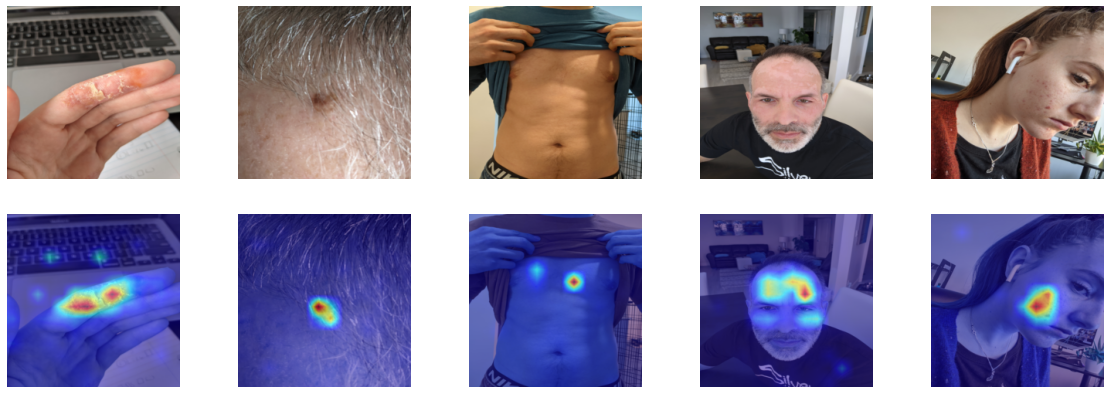

In [9]:
fig, axs = plt.subplots(2, len(images), figsize=(20,7))
for i, image in enumerate(images): 
    img = image_reader(bucket, image)
    img = Image.fromarray(img)
    image = transform(img)
    axs[0, i].imshow(resizing(img));
    axs[0, i].axis('off');

    output = model(image.unsqueeze(0).cuda())
    print_top_classes(output)

    # dog 
    # generate visualization for class 243: 'bull mastiff'
    mask_image = generate_visualization(image, class_index=diseases[i])

    #axs[1].imshow(cat);
    #axs[1].axis('off');
    axs[1, i].imshow(mask_image);
    axs[1, i].axis('off');
plt.savefig('maps.pdf')